# Assignment 3
# Part 3

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
import sys

drive.mount('/content/drive')

# Adjust the path to point to the folder in my Google Drive
folder_path = '/content/drive/My Drive/DIT867_AML/Assignment_3'
sys.path.append(folder_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Transformation

In [ ]:
data = pd.read_csv(f'{folder_path}/a3_train.csv', header=None)
data.head(10)

,0,1
0,1,I'll only consume if I know what's inside it....
1,0,It is easier to fool a million people than it...
2,0,NATURAL IMMUNITY protected us since evolutio...
3,1,NATURAL IMMUNITY protected us since evolutio...
4,0,"Proud to have resisted. Proud of my husband, ..."
5,1,The bigest sideffect of vaccines is fewer dea...
6,1,Vaccine takes more than a year to develop. T...
7,0,YES IM A TRUCKER FROM USA AND I WONT GET VACC...
8,0,"covid vaccines are safe , Goes to show , if ..."
9,1,just because I don't have dr in front of my n...


## Training and Testing

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

In [ ]:
# Rename to work with easier flow
Xtrain = data[1]
Ytrain = data[0]

# Vectorize the data
vectorizer = TfidfVectorizer()
Xtrain_vect = vectorizer.fit_transform(Xtrain)

# Initialize the models
models = {
    'Dummy Classifier': DummyClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Perceptron': Perceptron(),
    'Naive Bayes': MultinomialNB()
}

baseline_models = {name: cross_val_score(model, Xtrain_vect, Ytrain, cv=5).mean() for name, model in models.items()}

In [ ]:
baseline_models

{'Dummy Classifier': 0.5100803957946815,
 'Logistic Regression': 0.796969696969697,
 'Perceptron': 0.7430839002267573,
 'Naive Bayes': 0.7916718202432488}

## We continue with Logistic Regression and Naive Bayes

## Naive Bayes and N-grams

In [ ]:
print(Xtrain[5])

 The bigest sideffect of vaccines is fewer dead children  That is savage


In [ ]:
ngram = CountVectorizer(analyzer='word', ngram_range=(1,3))
# Extract from a comment
ngram.fit_transform([Xtrain[5]],)
ngram.get_feature_names_out()

array(['bigest', 'bigest sideffect', 'bigest sideffect of', 'children',
       'children that', 'children that is', 'dead', 'dead children',
       'dead children that', 'fewer', 'fewer dead', 'fewer dead children',
       'is', 'is fewer', 'is fewer dead', 'is savage', 'of',
       'of vaccines', 'of vaccines is', 'savage', 'sideffect',
       'sideffect of', 'sideffect of vaccines', 'that', 'that is',
       'that is savage', 'the', 'the bigest', 'the bigest sideffect',
       'vaccines', 'vaccines is', 'vaccines is fewer'], dtype=object)

### Checking the value of adding Ngrams

In [ ]:
gram_clf = Pipeline([
    ('vect', CountVectorizer(analyzer='word')),
    ('clf', MultinomialNB()),
])

grams_dict = {}
for i in range(1,6):
    gram_clf.set_params(vect__ngram_range=(1,i))
    gram_train = cross_val_score(gram_clf, Xtrain, Ytrain).mean()
    grams_dict[i] = gram_train

Text(0.5, 1.0, 'N-Grams accuracy')

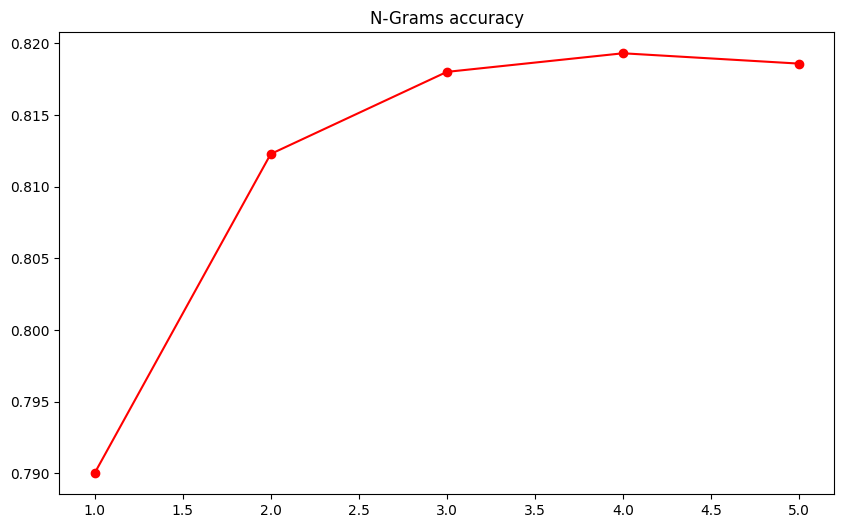

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(grams_dict.keys(), grams_dict.values(), color='red', marker='o', label='Training')
plt.title("N-Grams accuracy")

In line with the theory of Markov chains, adding infinite ngrams does not improve the model; ngrams between 3 and 4 should be enough.

In [ ]:
from sklearn.model_selection import GridSearchCV

gram_clf = Pipeline([
    ('vect', CountVectorizer(analyzer='word')),
    ('clf', MultinomialNB()),
])

param_grid = {
    'vect__ngram_range': [(1,x) for x in range(2,5)],
    'vect__stop_words': (None, 'english'),
    'vect__max_df': [x / 10.0 for x in range(1, 10, 2)],
    }


gs_gram_clf = GridSearchCV(gram_clf,
                           param_grid,
                           cv=5,
                           n_jobs=-1)

gs_gram_clf.fit(Xtrain, Ytrain)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'vect__max_df': [0.1, 0.3, 0.5, 0.7, 0.9],
                         'vect__ngram_range': [(1, 2), (1, 3), (1, 4)],
                         'vect__stop_words': (None, 'english')})

In [ ]:
results = pd.DataFrame(gs_gram_clf.cv_results_).sort_values(by=['mean_test_score'], ascending=False)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vect__max_df,param_vect__ngram_range,param_vect__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,20.378082,0.949541,1.940373,0.518661,0.3,"(1, 4)",None,"{'vect__max_df': 0.3, 'vect__ngram_range': (1,...",0.821171,0.816739,0.822717,0.823954,0.815502,0.820016,0.003324,1
4,20.906769,1.131862,1.589581,0.161567,0.1,"(1, 4)",None,"{'vect__max_df': 0.1, 'vect__ngram_range': (1,...",0.822099,0.817254,0.821686,0.821892,0.814884,0.819563,0.002953,2
2,11.624052,0.534489,2.213857,0.075714,0.1,"(1, 3)",None,"{'vect__max_df': 0.1, 'vect__ngram_range': (1,...",0.822202,0.817254,0.820759,0.820862,0.816327,0.819481,0.002274,3
16,20.499349,0.933192,1.814163,0.433889,0.5,"(1, 4)",None,"{'vect__max_df': 0.5, 'vect__ngram_range': (1,...",0.821171,0.815296,0.823026,0.822923,0.814471,0.819377,0.003737,4
22,21.068078,1.225968,1.851436,0.494998,0.7,"(1, 4)",None,"{'vect__max_df': 0.7, 'vect__ngram_range': (1,...",0.821171,0.815296,0.822717,0.822923,0.814471,0.819316,0.003678,5


In [ ]:
gs_gram_clf.best_params_

{'vect__max_df': 0.3, 'vect__ngram_range': (1, 4), 'vect__stop_words': None}

## Test data

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

test = pd.read_csv(f'{folder_path}/a3_test.tsv', sep='\t', header=None)
Xtest = test[1]
Ytest = test[0]

In [ ]:
gram_clf.set_params(vect__ngram_range=(1,4), vect__stop_words = None, vect__max_df = 0.3)
gram3_trained = gram_clf.fit(Xtrain, Ytrain)
Yhat = gram3_trained.predict(Xtest)
print(accuracy_score(Ytest, Yhat))

0.8847474252084355


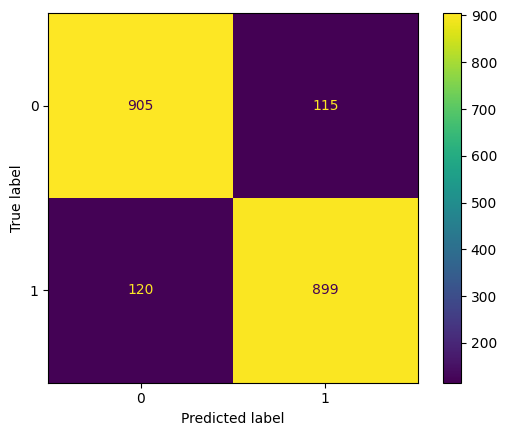

In [ ]:
cmatrix = confusion_matrix(Ytest, Yhat)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cmatrix)
cm_plot.plot()
plt.show()

Assuming positive is a Provax stance

In [ ]:
false_positive = [x for x,yt,yh in zip(Xtest, Ytest, Yhat) if yh != yt and yh == 1]
false_negative = [x for x,yt,yh in zip(Xtest, Ytest, Yhat) if yh != yt and yh == 0]

In [ ]:
false_positive[0:5]

["It's safe because it wasn't rushed. I could make these videos, I just need a lab coat.",
 'Vaccines are saving lives meanwhile romania being the least vaccinated and also least infected country in the whole europe',
 "11 months on and still no symptoms. I feel great. No vaccine and have been visiting my 91 year old nan who smokes ALOT and she's fine. This is about depopulation a Eugenics program.",
 '2 years ago today I took a vaccine that I was led to believe would stop me catching covid, protect me from dying from covid as an asthmatic and someone with congenital heart disease, protect the little people I looked after in my classroom, stop me killing my nan. IT WAS BULLSHIT',
 'About 4 months ago, I had COVID-19. I just got my first vaccine and I became very ill with fever, chills, body aches and dizzy spells. Now I’m afraid to get the second dose. Any suggestions?']

In [ ]:
false_negative[0:5]

["Don't tell me what to do with my body - the same people that want to enforce anti-abortion laws on women.",
 "I don't know what's in it. As if they know what's in the hamburgers they eat, the milk they drink, the high fructose corn syrup they consume... what a tragedy of stupidity.",
 'I trust my immune system just translates to "I don\'t know how vaccines work."',
 '99% of those who died from covid are unvaccinated',
 "A good friend is recovering after covid, having refused vaccination. He is confused and has trouble focusing. He remembers that he wasn't that way before. A solid hit with covid leaves patients with an average of a seven IQ point drop. He isn't an average victim. He's young and healthy and he's going to live with this damage for decades."]

In [ ]:
def get_unique_salient_words(nb_clf, vect, limit):
    """
    This is adapted from this answer in Stack https://stackoverflow.com/a/62466116
    Return salient words for given class
    Parameters
    ----------
    nb_clf : a Naive Bayes classifier (e.g. MultinomialNB, BernoulliNB)
    vect : CountVectorizer
    limit: n most important features to compare
    Returns
    -------
    dict: a sorted dictionary of unique important features for each class.
    """

    words = vect.get_feature_names_out()

    zipped_pos = list(zip(words, nb_clf.feature_log_prob_[1]))
    _ps = sorted(zipped_pos, key=lambda t: t[1], reverse=True)[:limit]

    zipped_neg = list(zip(words, nb_clf.feature_log_prob_[0]))
    _ng = sorted(zipped_neg, key=lambda t: t[1], reverse=True)[:limit]

    unique_words = dict()
    unique_words['Provax'] = [{tup[0]:tup[1]} for tup in _ps if tup[0] not in [t[0] for t in _ng]]
    unique_words['Antivax'] = [{tup[0]:tup[1]} for tup in _ng if tup[0] not in [t[0] for t in _ps] ]

    return unique_words

dict_salient_words = get_unique_salient_words(gram3_trained[1], gram3_trained[:-1], limit=1000)

In [ ]:
dict_salient_words['Antivax'][:10]

[{'poison': -8.752857897880075},
 {'experimental': -8.867075867371963},
 {'my body': -9.047974948819373},
 {'the jab': -9.17513012430462},
 {'the government': -9.189764531823059},
 {'will not': -9.26898857387576},
 {'not taking': -9.301423849628913},
 {'pharma': -9.372577609885203},
 {'money': -9.393442748349166},
 {'not getting': -9.40556410888151}]

In [ ]:
dict_salient_words['Provax'][:10]

[{'got my': -8.341304261667958},
 {'my first': -8.68190873557408},
 {'anti vaxxers': -8.980275708125877},
 {'to protect': -9.010010307068757},
 {'available': -9.057393011470309},
 {'just got': -9.173595019129372},
 {'first dose': -9.185514111366583},
 {'my second': -9.204885177122584},
 {'able': -9.207333158761223},
 {'able to': -9.2653569988776}]